In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import datasets, layers, models, optimizers, regularizers
from keras.callbacks import EarlyStopping, Callback
from keras.utils import plot_model, to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.activations import linear, sigmoid, tanh, relu
from tensorflow.keras.layers import LeakyReLU, ELU
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from IPython.display import clear_output, display, Math

In [3]:
# Завантажуємо датасет і розділимо його на навчальну та тестову вибірки.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Нормалізуємо значення пікселів, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.
x_train, x_test = x_train / 255., x_test / 255.

In [4]:
# Визначення ранньої зупинки
early_stopping = EarlyStopping(
    monitor='val_loss',  # Моніторимо функцію втрат на валідаційному наборі даних
    patience=5,  # Кількість епох без покращення, після яких навчання буде припинено
    restore_best_weights=True  # Відновлення найкращих ваг моделі
)

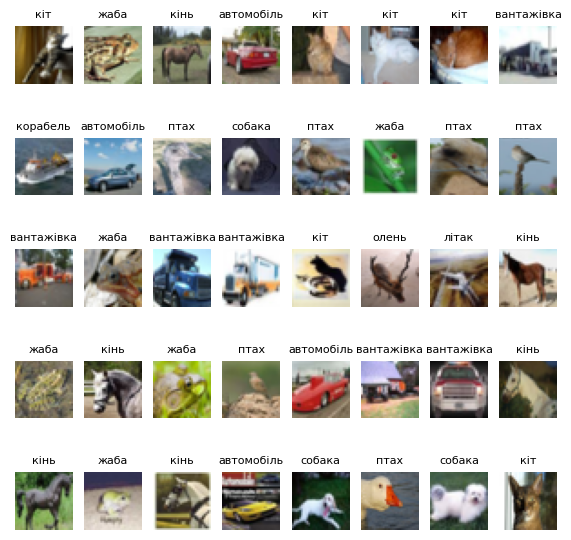

In [5]:
# Ось словник міток класів для CIFAR-10
class_labels = {
    0: 'літак', 
    1: 'автомобіль', 
    2: 'птах', 
    3: 'кіт', 
    4: 'олень', 
    5: 'собака', 
    6: 'жаба', 
    7: 'кінь', 
    8: 'корабель', 
    9: 'вантажівка'
}
number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(7, 7))

for i, sample_index in enumerate(np.random.randint(1, x_test.shape[0], number_of_images)):
    test_image = x_test[sample_index].reshape(1, -1)
    test_item = y_test[sample_index][0]  # Отримати перше значення (якщо y_test має більше одного значення)
    class_name = class_labels[test_item]

    ax[i//8, i % 8].imshow(test_image[0].reshape((32, 32, 3)))
    ax[i//8, i % 8].axis('off')
    ax[i//8, i % 8].set_title(f"{class_name}", fontsize=8)

plt.show()



C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


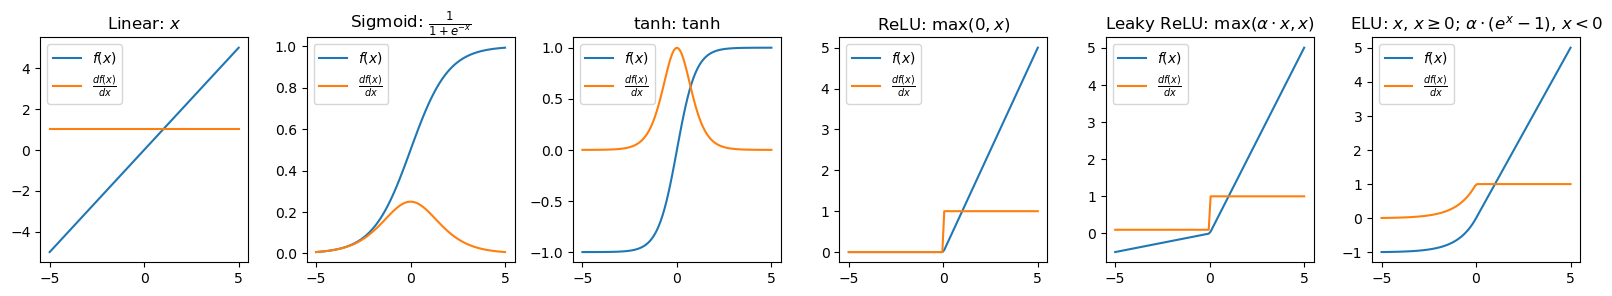

In [6]:
x = np.linspace(-5, 5, 100)
x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)

activation_functions = [linear, sigmoid, tanh, relu, LeakyReLU(alpha=0.1), ELU(alpha=1.0)]
activation_names = ['Linear', 'Sigmoid', 'tanh', 'ReLU', 'Leaky ReLU', 'ELU']
analitic = [r'$x$', r'$\frac{1}{1 + e^{-x}}$', r'$\tanh$', r'$\max(0, x)$', r'$\max(\alpha\cdot x, x)$', r'$x$, $x \geq 0$; $\alpha\cdot(e^x - 1)$, $x < 0$']


plt.figure(figsize=(16, 16))

for i in range(len(activation_functions)):
    activation_name = activation_names[i]

    plt.subplot(6, 6, i + 1)
    plt.plot(x, activation_functions[i](x_tensor).numpy(), label=r'$f(x)$')
    plt.title(f'{activation_name}: {analitic[i]}')

    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        y = activation_functions[i](x_tensor)
    derivative = tape.gradient(y, x_tensor).numpy()
    plt.plot(x, derivative, label=r'$\frac{df(x)}{dx}$')
    plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# Функція для побудови моделі
def build_model():
    model = models.Sequential()
    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(64, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(128, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.BatchNormalization(input_shape=x_train.shape[1:]))
    model.add(layers.Conv2D(256, (5, 5), padding="same", activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Activation("elu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10))
    model.add(layers.Activation("softmax"))

    return model

# Побудова моделі
model = build_model()

# Компіляція моделі
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Виведення опису моделі
model.summary()

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,081,430 (7.94 MB)

 Trainable params: 2,081,040 (7.94 MB)

 Non-trainable params: 390 (1.52 KB)

In [8]:
# Навчання моделі
history = model.fit(x_train, y_train, batch_size=256,
    epochs=150,
    validation_data=(x_test, y_test),
    
)

# Оцінка моделі на тестовому наборі даних
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'\nТочність на тестовому наборі: {test_accuracy:.2f}')

Epoch 1/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 199s 995ms/step - accuracy: 0.2558 - loss: 2.7160 - val_accuracy: 0.1210 - val_loss: 5.7851
Epoch 2/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 219s 1s/step - accuracy: 0.4481 - loss: 1.5921 - val_accuracy: 0.5875 - val_loss: 1.1968
Epoch 3/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.5627 - loss: 1.2293 - val_accuracy: 0.6741 - val_loss: 0.9382
Epoch 4/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6457 - loss: 1.0112 - val_accuracy: 0.6928 - val_loss: 0.9499
Epoch 5/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 306s 2s/step - accuracy: 0.6912 - loss: 0.8767 - val_accuracy: 0.7257 - val_loss: 0.8032
Epoch 6/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 285s 1s/step - accuracy: 0.7319 - loss: 0.7632 - val_accuracy: 0.7553 - val_loss: 0.7060
Epoch 7/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7597 - loss: 0.6826 - val_accuracy: 0.7551 - val_loss: 0.7276
Epoch 8/150
196/196 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.7840 - loss: 0.6092

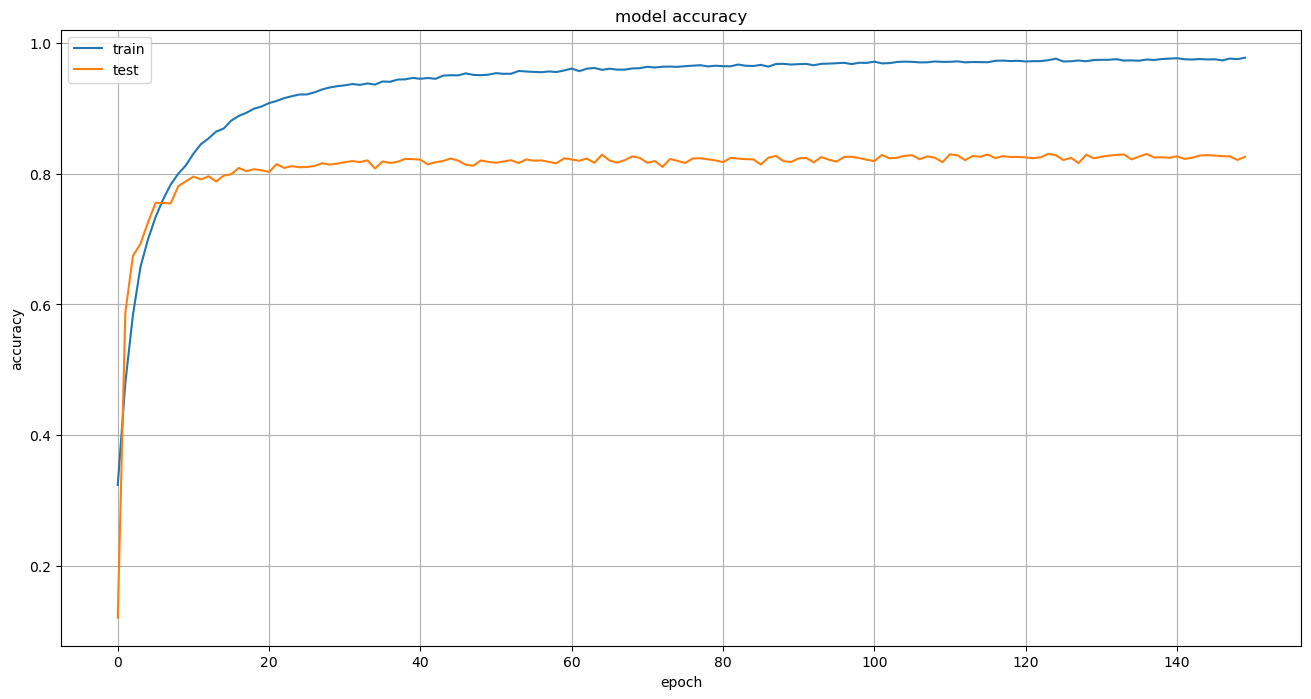

In [9]:
# plotting helper function
def plothist(hist):
    plt.rcParams["figure.figsize"] = (16, 8)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

plothist(history)


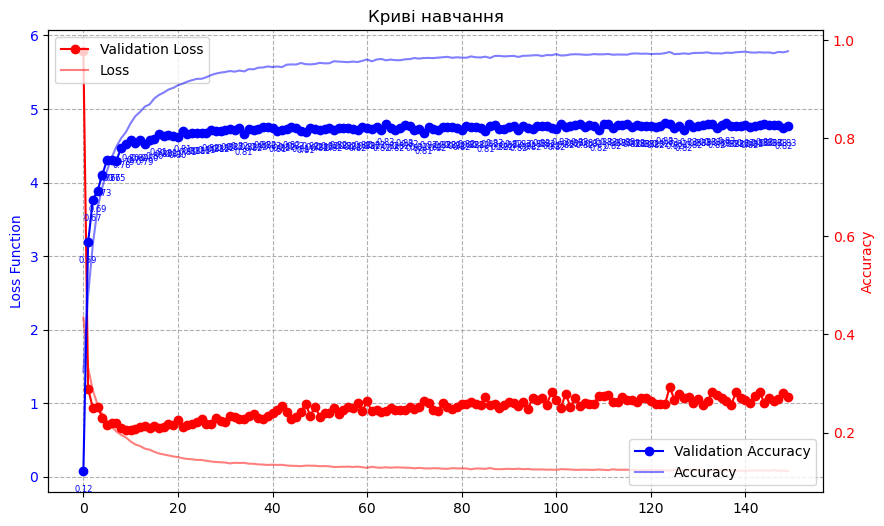

In [10]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(history.history['val_loss'], label='Validation Loss', marker='o', color='r')
ax1.plot(history.history['loss'], label='Loss', color='r', alpha=0.5)
ax1.set_ylabel('Loss Function', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.plot(history.history['val_accuracy'], label='Validation Accuracy',  marker='o', color='b')
ax2.plot(history.history['accuracy'], label='Accuracy', color='b', alpha=0.5)
                         
for i, acc in enumerate(history.history['val_accuracy']):
    ax2.annotate(f'{acc:.2f}', (i, acc), textcoords="offset points", xytext=(0, -15), ha='center', c='b', fontsize=6)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.grid(True, linestyle='--') 

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title('Криві навчання')

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


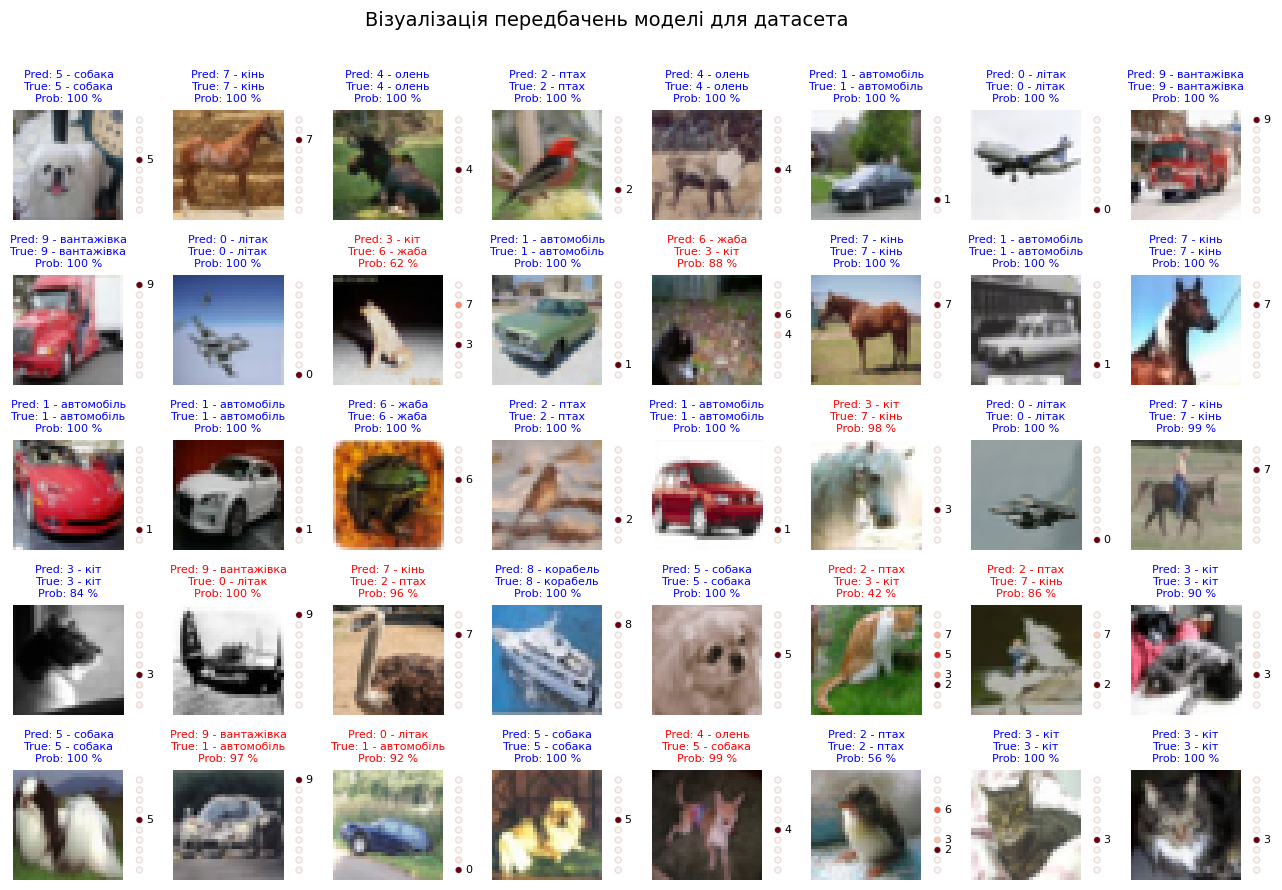

In [11]:
predictions = model.predict(x_test)


number_of_images = 40
f, ax = plt.subplots(5, 8, figsize=(16, 10))
f.subplots_adjust(hspace=0.5, wspace=0.3)

f.suptitle("Візуалізація передбачень моделі для датасета", fontsize=14)


for axes_index, sample_index in enumerate(np.random.choice(10000, number_of_images)):
    prob = predictions[sample_index]
    img, true_label = x_test[sample_index], y_test[sample_index]
    predicted_label = np.argmax(prob)
    if predicted_label == true_label:
        color = 'blue'
        cmap = 'Blues'
    else:
        color = 'red'
        cmap = 'Reds'

    ax[axes_index//8, axes_index % 8].imshow(img, cmap=cmap)
    ax[axes_index//8, axes_index % 8].axis('off')
    ax[axes_index//8, axes_index % 8].set_title(f"Pred: {predicted_label} - {class_labels.get(predicted_label)}\nTrue: {true_label[0]} - {class_labels.get(true_label[0])}\nProb: {prob.max()*100:.0f} %", fontsize=8, color=color)

    
    inset_ax = f.add_axes([ax[axes_index//8, axes_index % 8].get_position().x1, ax[axes_index//8, axes_index % 8].get_position().y0, 0.02, ax[axes_index//8, axes_index % 8].get_position().height])

    classes = np.arange(len(class_labels))
    inset_ax.scatter(np.ones(10)*0.5, 
                     classes, 
                     s=20, 
                     c=prob, 
                     cmap='Reds', 
                     marker='o',
                     edgecolor=(0.5, 0.5, 0.5, 0.2),
                     linewidths=1,
                     )
    inset_ax.set_xlim(0, 1)
    inset_ax.set_ylim(-1, 10)
    inset_ax.set_xticks([])
    inset_ax.set_yticks([])
    inset_ax.axis('off')
    for i, p in enumerate(prob):
        if p > 0.1:
            inset_ax.text(0.7, i, f'{i}', fontsize=8, verticalalignment='center')

plt.show()

In [12]:
model.save("cifar10_best_latest.h5")